In [133]:
%matplotlib inline
import seaborn as sbn
sbn.set_style('white')
import numpy as np
from skimage.io import imsave
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.manifold import TSNE

from keras.models import Model
from keras.layers import InputLayer
from keras import backend as K

from machinedesign.autoencoder.interface import load
from machinedesign.viz import grid_of_images_default
from sklearn.ensemble import RandomForestClassifier

from PIL import Image

import math

from collections import defaultdict
from scipy.spatial.distance import cdist
from lapjv import lapjv

def grid_embedding(h):
    assert int(np.sqrt(h.shape[0])) ** 2 == h.shape[0], 'Nb of examples must be a square number'
    size = np.sqrt(h.shape[0])
    grid = np.dstack(np.meshgrid(np.linspace(0, 1, size), np.linspace(0, 1, size))).reshape(-1, 2)
    cost_matrix = cdist(grid, h, "sqeuclidean").astype('float32')
    cost_matrix = cost_matrix * (100000 / cost_matrix.max())
    _, rows, cols = lapjv(cost_matrix)
    return rows

def convert_to_RGBA(img, alpha=None):
    """Converts input PIL Image or nparray to RGBA. Returns ndarray of shape
    (H, W, 4), where the last channel dimension is `alpha`, the transparency"""
    try:
        if img.mode != "RGBA":
            img = np.array(img.convert("RGBA"))
    except AttributeError:
        img = Image.fromarray(img)
        if img.mode != "RGBA":
            img = np.array(img.convert("RGBA"))
    # reconvert back to npy. we converted ^ to make sure any array is converted
    # to a standard color mode, RGBA, so we can manpipualate easily
    if alpha is not None:
        if alpha >= 0 and alpha <= 255:
            img[:, :, 3] = int(alpha)
        else:
            raise RuntimeError("alpha must be between [0, 255]")

    return np.array(img)


def preproc_img(img, flip_ud=True, alpha=None):
    """ Preprocess a image arr (numpy or PIL.Image) to be absorbed bokeh's
    plotting."""
    # convert to RGBA if it's not, depending on whether ndarr/PIL.Image
    img = convert_to_RGBA(img, alpha=alpha)

    # traditional image conventions refer to top left corner as 0,0.
    # however, bokeh has bottom left (0,0).
    if flip_ud:
        img = np.flipud(img)

    # convert img to be 2d arr (M x N) with dtype = uint32 -- for bokeh
    bimg = np.squeeze(img.astype(np.uint8).view(np.uint32))
    return bimg
def plot_dataset(code_2d, categories):
    colors = [
        'r',
        'b',
        'g',
        'crimson',
        'gold',
        'yellow',
        'maroon',
        'm',
        'c',
        'orange'
    ]
    for cat in range(0, 10):
        g = (categories == cat)
        plt.scatter(
            code_2d[g, 0],
            code_2d[g, 1],
            marker='+',
            c=colors[cat],
            s=40,
            alpha=0.7,
            label="digit {}".format(cat)
        )


def plot_generated(code_2d, categories):
    g = (categories < 0)
    plt.scatter(
        code_2d[g, 0],
        code_2d[g, 1],
        marker='+',
        c='gray',
        s=30
    )

In [205]:
folder = 'mnist'

In [206]:
model = load('results/{}'.format(folder))

In [207]:
def id_of(f, it):
    for i, x in enumerate(it):
        if f(x):
            return i

In [208]:
layer_id = id_of(lambda l:l.__class__.__name__ == 'winner_take_all_spatial', model.layers)
layer_c, layer_h, layer_w = model.layers[layer_id].output_shape[1:]

enc = Model(model.layers[0].input, model.layers[layer_id].output)
x = K.placeholder((None, layer_c, layer_h, layer_w))
h = x
for l in model.layers[layer_id + 1:]:
    h = l(h)
dec = K.function([x], [h])

In [277]:
dataset = '../data/digits.npz'
data = np.load(dataset)
X, y = data['X'], data['y']
X = X.astype(np.float32)
X /= 255.

In [141]:
h = np.zeros((layer_c, layer_c, layer_h, layer_w))
ind = np.arange(len(h))
h[ind, ind, 8, 8] = 20
xrec, = dec([h])
im = grid_of_images_default(xrec)
imsave('results/{}/features.png'.format(folder), im)

/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [142]:
def featurize(h):
    y, x = np.indices((layer_h, layer_w))
    y = y[np.newaxis, np.newaxis, :, :]
    x = x[np.newaxis, np.newaxis, :, :]
    hx = (h > 0) * x 
    hy = (h > 0) * y
    hx = hx.max(axis=(2, 3))
    hy = hy.max(axis=(2, 3))
    hx = hx.astype(np.float32)
    hy = hy.astype(np.float32)
    hy /= layer_h
    hx /= layer_w
    h = np.concatenate((hx, hy), axis=1)
    return h

In [144]:
gen = np.load('results/{}/gen/generated.npz'.format(folder))
nb_gen = 2 * (2 * 40 * 40)
Xg = gen['generated'][0:nb_gen]
yg = np.array([-1] * len(Xg))
Xt = X[0:len(Xg)]
yt = y[0:len(yg)]
Xf = np.concatenate((Xg, Xt), axis=0)
yf = np.concatenate((yg, yt), axis=0)
h = enc.predict(Xf)
h = featurize(h)
h2d = TSNE().fit_transform(h)

(6400, 1, 28, 28)


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


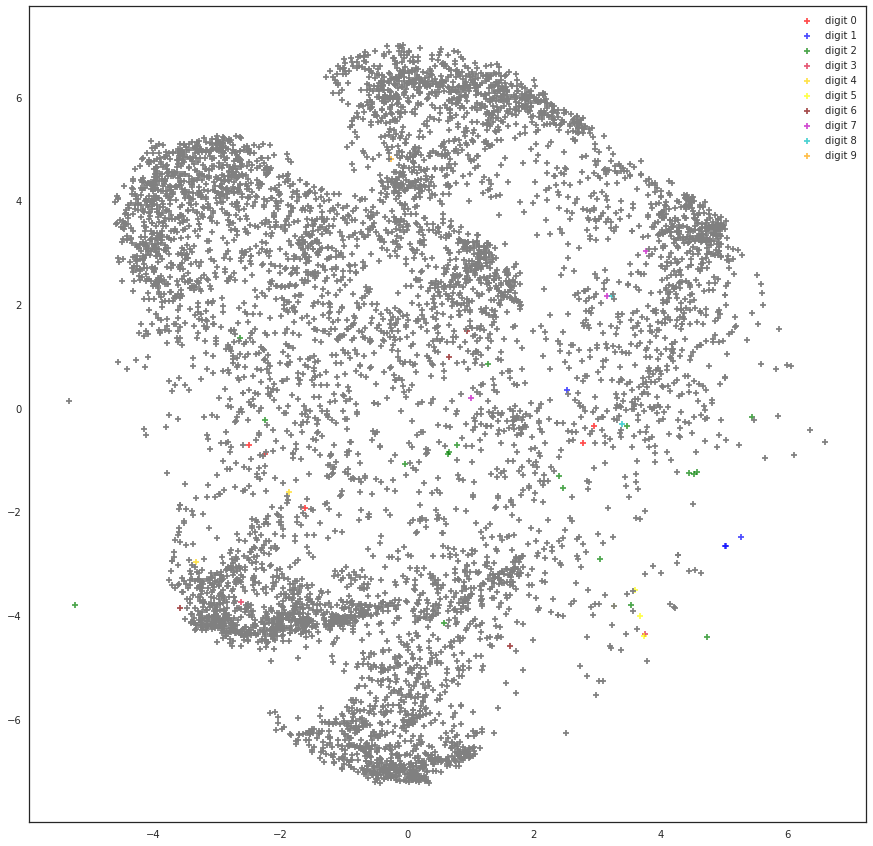

In [145]:
fig = plt.figure(figsize=(15, 15))
plot_dataset(h2d, yf)
plot_generated(h2d, yf)
plt.legend()
plt.show()

In [36]:
from bokeh.plotting import figure, output_file, show, save
output_file('results/{}/img_embedding.html'.format(folder))

x_range = (h2d[:, 1].min(), h2d[:, 1].max())
y_range = (h2d[:, 0].min(), h2d[:, 1].max())
p = figure(plot_width=1200, plot_height=800, x_range=x_range, y_range=y_range)

for coord, img in zip(h2d, Xf):
    img = img[0]
    img = img * 255.
    img = img.astype(np.float32)
    img = Image.fromarray(img)
    img = preproc_img(img)
    y = coord[0]
    x = coord[1]
    p.image_rgba(image=[img], 
                 x=[y],
                 y=[x], 
                 dw=[0.1], dh=[0.1])

save(p)

KeyboardInterrupt: 

In [158]:
nb = 30*30*2
xx = np.concatenate((Xf[0:nb], Xf[nb_gen:nb_gen + nb]), axis=0)
hh = np.concatenate((h2d[0:nb], h2d[nb_gen:nb_gen + nb]), axis=0)
xx[0:nb] = 1.0 - xx[0:nb]
rows = grid_embedding(hh)
im = grid_of_images_default(xx[rows])
imsave('results/{}/grid.png'.format(folder), im)

/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:29: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


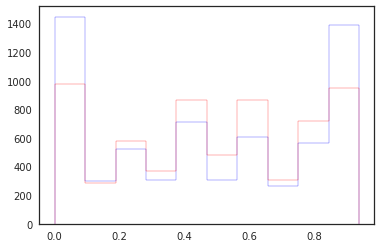

In [161]:
plt.hist(h[yf<0, 2], color='blue', histtype='step')
plt.hist(h[yf>=0, 2], color='red', histtype='step')
plt.show()

In [109]:
# Computes normalized mutual information between all possible pairs of features
ind = np.arange(h.shape[1]//2, h.shape[1])
np.random.shuffle(ind)
h_ = h[:, ind]
m = np.zeros((h_.shape[1], h_.shape[1]))
for i in range(h_.shape[1]):
    for j in range(i, h_.shape[1]):
        ij_counts = defaultdict(int)
        icounts = defaultdict(int)
        jcounts = defaultdict(int)
        for k in range(0, 1000):
            ij_counts[(h_[k, i], h_[k, j])] += 1
            icounts[h_[k, i]] += 1
            jcounts[h_[k, j]] += 1
        ij_total = sum(ij_counts.values())
        i_total = sum(icounts.values())
        j_total = sum(jcounts.values())
        m[i, j] = 0.
        for (vi, vj), nb in ij_counts.items():
            pij = nb / ij_total
            pi = icounts[vi] / i_total
            pj = jcounts[vj] / j_total
            m[i, j] += pij * math.log(pij / (pi * pj))
        hi = sum((nb/i_total) * math.log(nb/i_total) for nb in icounts.values())
        hj = sum((nb/j_total) * math.log(nb/j_total) for nb in jcounts.values())
        m[i, j] /= math.sqrt(hi * hj)

/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


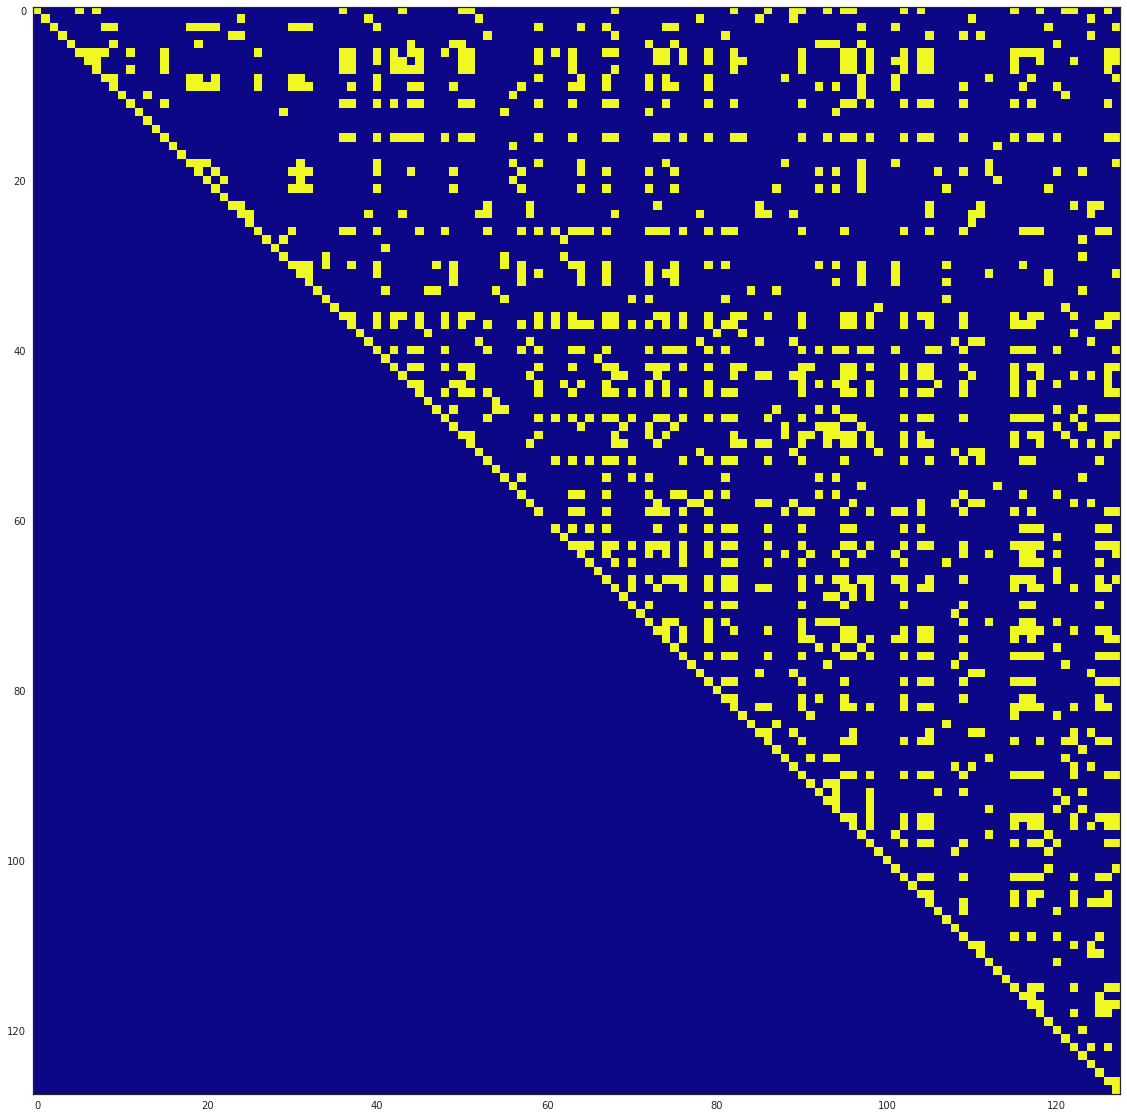

In [113]:
fig = plt.figure(figsize=(20, 20))
plt.imshow(m>0.3, cmap='plasma')

In [283]:
x = K.placeholder((None, 1, 28, 28))
y = x
for t in range(10):
    for l in model.layers:
        y = l(y)
loss = y[:, :, 13, 13].mean()
g = K.gradients(loss, x)
get_g = K.function([x], g)
pred = K.function([x], y)

370.0


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


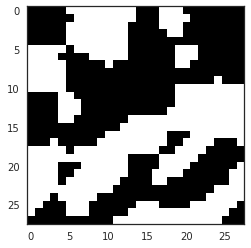

In [294]:
#v = np.random.uniform(size=(1, 1, 28, 28)).astype(np.float32)
#v = np.ones((1, 1, 28, 28)).astype(np.float32)
#v = X[0:1]
gval = (get_g([v])>0).astype(np.float32)
print(gval.sum())
plt.imshow(gval[0, 0], cmap='gray')
plt.show()

/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


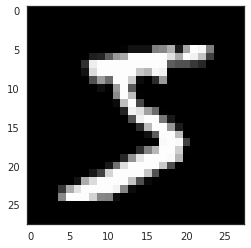

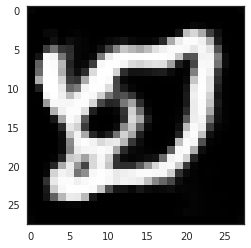

In [291]:
v = np.random.uniform(size=(1, 1, 28, 28)).astype(np.float32)
y=pred([v])
plt.imshow(X[0,0], cmap='gray')
plt.show()
plt.imshow(y[0,0], cmap='gray')
plt.show()